# MLP

In [1]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

# set print options to avoid scientific notation
torch.set_printoptions(sci_mode=False, precision=2)

In [2]:
from datasets import load_dataset
import numpy as np

# load the MNIST dataset
ds = load_dataset("ylecun/mnist")
ds

# convert PIL image to normalized PyToch tensor
def image_to_tensor(image):
    return torch.tensor(np.array(image)) / 255.0


def preprocess_data(split):
    
    x = []  # list to store image tensors
    y = []  # list to store labels

    for example in split:
        x.append(image_to_tensor(example['image']))
        y.append(example['label'])
    
    return torch.stack(x), torch.tensor(y)

train_x, train_y = preprocess_data(ds['train'])
test_x,  test_y  = preprocess_data(ds['test'])

torch.manual_seed(2)

# shuffle the test set before splitting
indices = torch.randperm(10000)
test_x, test_y = test_x[indices], test_y[indices]

# split the test dataset into validation and test sets
val_x, test_x = test_x[:5000], test_x[5000:]
val_y, test_y = test_y[:5000], test_y[5000:]

## MLP

In [3]:
def initialize_nn(n_hidden = 100):

    g = torch.Generator().manual_seed(1)
    
    W1 = torch.randn((784, n_hidden),      generator=g)
    b1 = torch.randn(n_hidden,             generator=g)
    W2 = torch.randn((n_hidden, n_hidden), generator=g)
    b2 = torch.randn(n_hidden,             generator=g)
    W3 = torch.randn((n_hidden, 10),       generator=g)
    b3 = torch.randn(10,                   generator=g)
    
    parameters = [W1, b1, W2, b2, W3, b3]
    
    for p in parameters:
        p.requires_grad = True
    
    return parameters

## Loss function

In [4]:
# intialize neural network
parameters = initialize_nn()
W1, b1, W2, b2, W3, b3 = parameters

In [5]:
epochs = 100     # train iterations
lr = 0.1           # learning rate
loss_graph = []

for epoch in range(epochs):
    
    # forward pass
    h1 = torch.tanh(train_x.view(-1, 784) @ W1 + b1) # (examples, n_hidden) = (examples, 784) x (784, n_hidden) + (n_hidden)
    h2 = torch.tanh(h1 @ W2 + b2)
    o = h2 @ W3 + b3                     # (examples, 10) = (examples, n_hidden) x (n_hidden, 10) + (10)
    probs = o.exp() / o.exp().sum(1, keepdims=True)  # softmax

    # calculate loss
    loss = -probs[torch.arange(o.shape[0]), train_y].log().mean()
    loss_graph.append(loss.item())
    if epoch % 10 == 0 or epoch == epochs - 1:
        print(f"Step: {epoch:2d}/{epochs}     Loss: {loss.item():.4f}")
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update parameters
    for p in parameters:
        p.data += -lr * p.grad

Step:  0/100     Loss: 13.3980
Step: 10/100     Loss: 8.9427
Step: 20/100     Loss: 7.1138
Step: 30/100     Loss: 5.9752
Step: 40/100     Loss: 5.1816
Step: 50/100     Loss: 4.6020
Step: 60/100     Loss: 4.1700
Step: 70/100     Loss: 3.8321
Step: 80/100     Loss: 3.5580
Step: 90/100     Loss: 3.3304
Step: 99/100     Loss: 3.1562


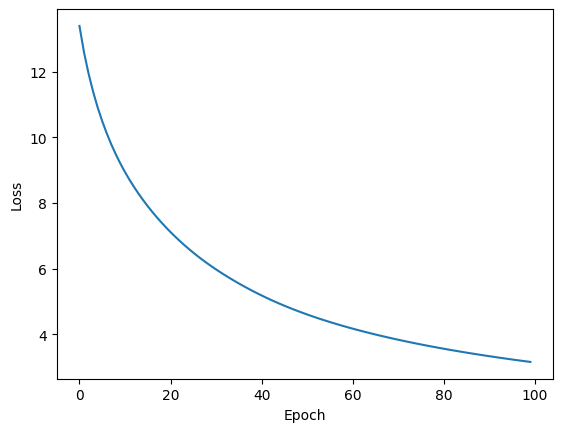

In [6]:
plt.plot(loss_graph)
plt.xlabel('Epoch')
plt.ylabel('Loss');

## Batches

As observed, the neural network was slowly reducing the loss, and therfore learning. However,each training step took a considerable amount of time to complete because it is quite computatuonally expensive to process the entire dataset of 60,000 examples for both forward and backward passes.

To address this issue, we will use **mini-batches** (small randomly selected subsets of the dataset) rather than the entire training set in each iteration. This approach reduces computation time while still maintaining the benefits of gradient descent.

```{admonition} Help
:class: dropdown
`torch.randint(0, X.shape[0], (32,))` randomly generates 32 integers between 0 and Xtr.shape[0] that index into our dataset.
```

In [7]:
# intialize neural network
parameters = initialize_nn()
W1, b1, W2, b2, W3, b3 = parameters

In [8]:
epochs = 100     # train iterations
lr = 0.1           # learning rate
batch_size = 32
loss_graph = []

for epoch in range(epochs):
    
    # batch construct
    ix = torch.randint(0, train_x.shape[0], (batch_size,))

    # forward pass
    h1 = torch.tanh(train_x[ix].view(-1, 784) @ W1 + b1) # (batch_size, n_hidden) = (batch_size, 784) x (784, n_hidden) + (n_hidden)
    h2 = torch.tanh(h1 @ W2 + b2)
    o = h2@ W3 + b3                    # (examples, n_hidden) = (examples, n_hidden) x (n_hidden, n_hidden) + (n_hidden)
    probs = o.exp() / o.exp().sum(1, keepdims=True)  # softmax

    
    # calculate loss
    loss = -probs[torch.arange(o.shape[0]), train_y[ix]].log().mean()


    loss_graph.append(loss.item())
    if epoch % 10 == 0 or epoch == epochs - 1:
        print(f"Step: {epoch:2d}/{epochs}     Loss: {loss.item():.4f}")
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update parameters
    for p in parameters:
        p.data += -lr * p.grad

Step:  0/100     Loss: 12.9742
Step: 10/100     Loss: 9.7200
Step: 20/100     Loss: 7.8978
Step: 30/100     Loss: 4.6707
Step: 40/100     Loss: 5.4760
Step: 50/100     Loss: 4.2005
Step: 60/100     Loss: 4.2056
Step: 70/100     Loss: 4.0334
Step: 80/100     Loss: 4.0929
Step: 90/100     Loss: 4.1738
Step: 99/100     Loss: 2.3037


The loss we see is the loss of each batch. The loss of the whole dataset is:

In [9]:
h1 = torch.tanh(train_x.view(-1, 784) @ W1 + b1) # (batch_size, n_hidden) = (batch_size, 784) x (784, n_hidden) + (n_hidden)
h2 = torch.tanh(h1 @ W2 + b2)
o = h2@ W3 + b3                    # (examples, n_hidden) = (examples, n_hidden) x (n_hidden, n_hidden) + (n_hidden)
probs = o.exp() / o.exp().sum(1, keepdims=True)  # softmax

    
    # calculate loss
loss = -probs[torch.arange(o.shape[0]), train_y].log().mean()
loss

tensor(3.28, grad_fn=<NegBackward0>)

This way we can run **many examples** nearly instantly and decrease the loss **much faster**. Because we are only dealing with mini-batches the quality of our gradient is lower (it is not the actual gradient direction) but the gradient direction is good enough even when it is estimating on only 32 examples. Thus, it is better to evaluate an approximate gradient, and just make more faster steps, than evaluate the exact gradient, and take fewer lower steps.

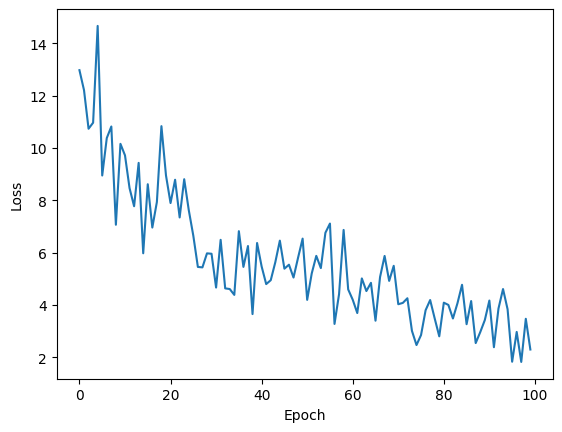

In [10]:
plt.plot(loss_graph)
plt.xlabel('Epoch')
plt.ylabel('Loss');

## Intialization

On epoch step 0 we got a loss of 12.97. Then, the loss rapidly decreased to 11. **We should expect a lower loss at initialization**.

At initialization we have no reason to believe that any number is more likely than other. Thus, initially we should expect a uniform probabilty distribution assigning about equal probability (1/10) to all the 10 numbers. Hence, we should expect an **initialization loss** close to:

In [11]:
-torch.tensor(1/10).log()

tensor(2.30)

In [12]:
# intialize neural network
parameters = initialize_nn()
W1, b1, W2, b2, W3, b3 = parameters

In [13]:
# batch construct
ix = torch.randint(0, train_x.shape[0], (batch_size,))

# forward pass
h1 = torch.tanh(train_x[ix].view(-1, 784) @ W1 + b1) # (batch_size, n_hidden) = (batch_size, 784) x (784, n_hidden) + (n_hidden)
h2 = torch.tanh(h1 @ W2 + b2)
o = h2@ W3 + b3                    # (examples, n_hidden) = (examples, n_hidden) x (n_hidden, n_hidden) + (n_hidden)
probs = o.exp() / o.exp().sum(1, keepdims=True)  # softmax

The issue is that at initialization the **logits coming out of the neural net are not uniform** (they are extreme randomly positive or negative numbers). Some characters are very confident and some characters are very not confident so the network is very confidently wrong recording a high loss.

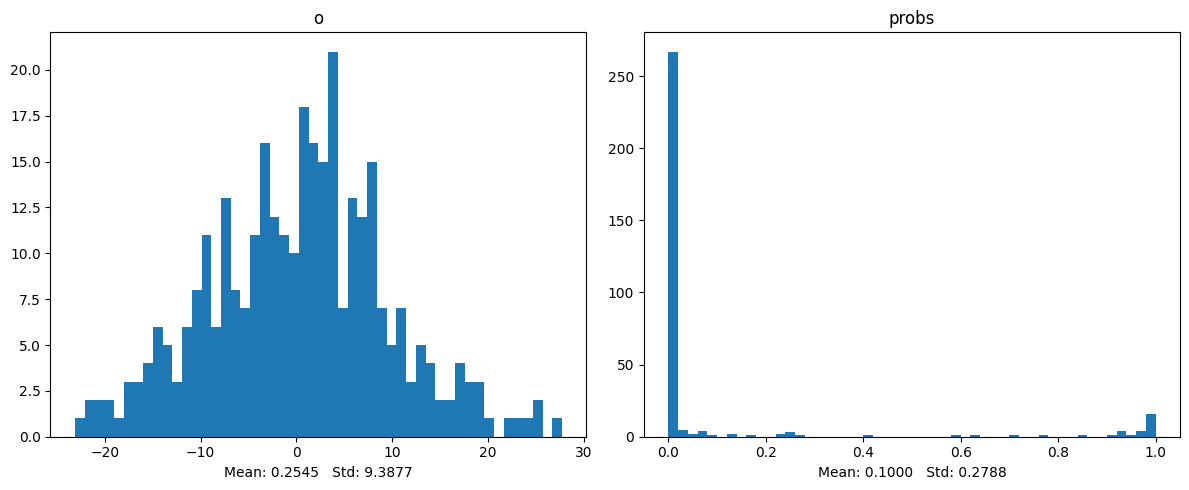

In [14]:
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.hist(o.view(-1).tolist(), 50)
plt.title('o')
plt.xlabel(f'Mean: {o.mean():.4f}   Std: {o.std():.4f}')

plt.subplot(122)
plt.hist(probs.view(-1).tolist(), 50)
plt.title('probs')
plt.xlabel(f'Mean: {probs.mean():.4f}   Std: {probs.std():.4f}')

plt.tight_layout()

In [28]:
def initialize_nn(n_hidden = 100):

    g = torch.Generator().manual_seed(1)
    
    W1 = torch.randn((784, n_hidden),      generator=g)
    b1 = torch.randn(n_hidden,             generator=g)
    W2 = torch.randn((n_hidden, n_hidden), generator=g)
    b2 = torch.randn(n_hidden,             generator=g)
    W3 = torch.randn((n_hidden, 10),       generator=g) * 0.1
    b3 = torch.randn(10,                   generator=g) * 0
    
    parameters = [W1, b1, W2, b2, W3, b3]
    
    for p in parameters:
        p.requires_grad = True
    
    return parameters

In [29]:
# intialize neural network
parameters = initialize_nn()
W1, b1, W2, b2, W3, b3 = parameters

In [30]:
# batch construct
ix = torch.randint(0, train_x.shape[0], (batch_size,))

# forward pass
h1 = torch.tanh(train_x[ix].view(-1, 784) @ W1 + b1) # (batch_size, n_hidden) = (batch_size, 784) x (784, n_hidden) + (n_hidden)
h2 = torch.tanh(h1 @ W2 + b2)
o = h2@ W3 + b3                    # (examples, n_hidden) = (examples, n_hidden) x (n_hidden, n_hidden) + (n_hidden)
probs = o.exp() / o.exp().sum(1, keepdims=True)  # softmax

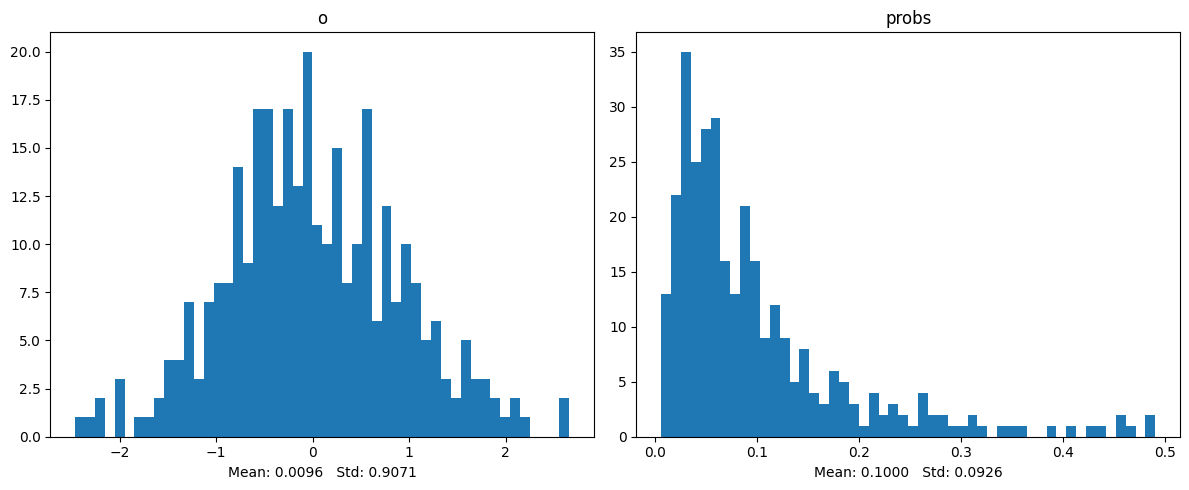

In [31]:
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.hist(o.view(-1).tolist(), 50)
plt.title('o')
plt.xlabel(f'Mean: {o.mean():.4f}   Std: {o.std():.4f}')

plt.subplot(122)
plt.hist(probs.view(-1).tolist(), 50)
plt.title('probs')
plt.xlabel(f'Mean: {probs.mean():.4f}   Std: {probs.std():.4f}')

plt.tight_layout()

In [168]:
# intialize neural network
parameters = initialize_nn()
W1, b1, W2, b2, W3, b3 = parameters

In [169]:
epochs = 100     # train iterations
lr = 0.1           # learning rate
batch_size = 32
loss_graph = []

for epoch in range(epochs):
    
    # batch construct
    ix = torch.randint(0, train_x.shape[0], (batch_size,))

    # forward pass
    h1 = torch.tanh(train_x[ix].view(-1, 784) @ W1 + b1) # (batch_size, n_hidden) = (batch_size, 784) x (784, n_hidden) + (n_hidden)
    h2 = torch.tanh(h1 @ W2 + b2)
    o = h2@ W3 + b3                    # (examples, n_hidden) = (examples, n_hidden) x (n_hidden, n_hidden) + (n_hidden)
    probs = o.exp() / o.exp().sum(1, keepdims=True)  # softmax

    
    # calculate loss
    loss = -probs[torch.arange(o.shape[0]), train_y[ix]].log().mean()


    loss_graph.append(loss.item())
    if epoch % 10 == 0 or epoch == epochs - 1:
        print(f"Step: {epoch:2d}/{epochs}     Loss: {loss.item():.4f}")
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update parameters
    for p in parameters:
        p.data += -lr * p.grad

Step:  0/100     Loss: 2.1769
Step: 10/100     Loss: 2.1511
Step: 20/100     Loss: 1.9224
Step: 30/100     Loss: 1.6237
Step: 40/100     Loss: 1.3478
Step: 50/100     Loss: 1.6766
Step: 60/100     Loss: 1.7137
Step: 70/100     Loss: 1.1115
Step: 80/100     Loss: 0.9885
Step: 90/100     Loss: 1.0650
Step: 99/100     Loss: 1.0479


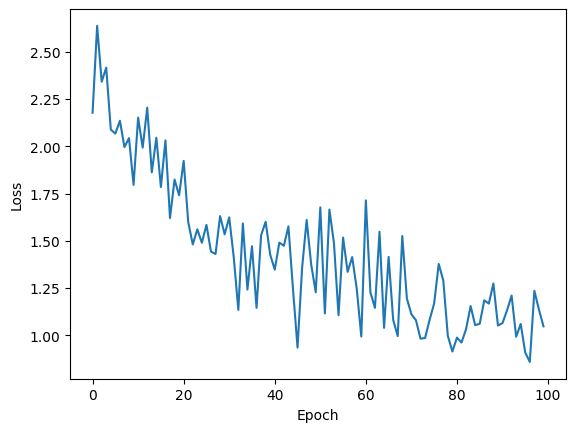

In [170]:
plt.plot(loss_graph)
plt.xlabel('Epoch')
plt.ylabel('Loss');

## Dead Neurons

Many of the 1st layer activations are either -1 or 1. This occurs because the pre-activations range between -20 and 20, leading the tanh function to saturate. As shown in the graph below, tanh squashes input values into the range [-1, 1], with large positive or negative inputs pushed closer to 1 or -1, respectively.

```{figure} ../images/tanh.png
---
width: 300px
name: tanh
---
tanh (Hyperbolic Tangent). Source: {cite}`weisstein_tanh`
```

In [172]:
# intialize neural network
parameters = initialize_nn()
W1, b1, W2, b2, W3, b3 = parameters

In [173]:
epochs = 100     # train iterations
lr = 0.1           # learning rate
batch_size = 32
loss_graph = []

for epoch in range(epochs):
    
    # batch construct
    ix = torch.randint(0, train_x.shape[0], (batch_size,))

    # forward pass

    h1_prev = train_x[ix].view(-1, 784) @ W1 + b1
    h1 = torch.tanh(h1_prev)
    h2_prev = h1 @ W2 + b2
    h2 = torch.tanh(h2_prev)
    o = h2@ W3 + b3                    # (examples, n_hidden) = (examples, n_hidden) x (n_hidden, n_hidden) + (n_hidden)
    probs = o.exp() / o.exp().sum(1, keepdims=True)  # softmax

    
    # calculate loss
    loss = -probs[torch.arange(o.shape[0]), train_y[ix]].log().mean()


    loss_graph.append(loss.item())
    if epoch % 10 == 0 or epoch == epochs - 1:
        print(f"Step: {epoch:2d}/{epochs}     Loss: {loss.item():.4f}")
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update parameters
    for p in parameters:
        p.data += -lr * p.grad

Step:  0/100     Loss: 2.4758
Step: 10/100     Loss: 1.8744
Step: 20/100     Loss: 1.5438
Step: 30/100     Loss: 1.6806
Step: 40/100     Loss: 1.2471
Step: 50/100     Loss: 1.4035
Step: 60/100     Loss: 1.0064
Step: 70/100     Loss: 0.9730
Step: 80/100     Loss: 0.9909
Step: 90/100     Loss: 1.0714
Step: 99/100     Loss: 1.2310


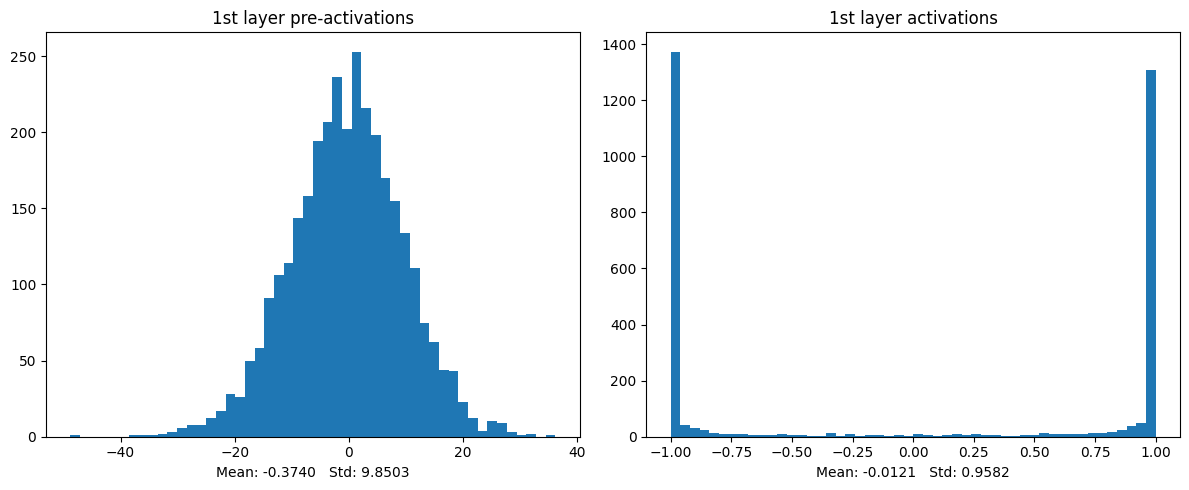

In [174]:
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.hist(h1_prev.view(-1).tolist(), 50)
plt.title('1st layer pre-activations')
plt.xlabel(f'Mean: {h1_prev.mean():.4f}   Std: {h1_prev.std():.4f}')

plt.subplot(122)
plt.hist(h1.view(-1).tolist(), 50)
plt.title('1st layer activations')
plt.xlabel(f'Mean: {h1.mean():.4f}   Std: {h1.std():.4f}')

plt.tight_layout()

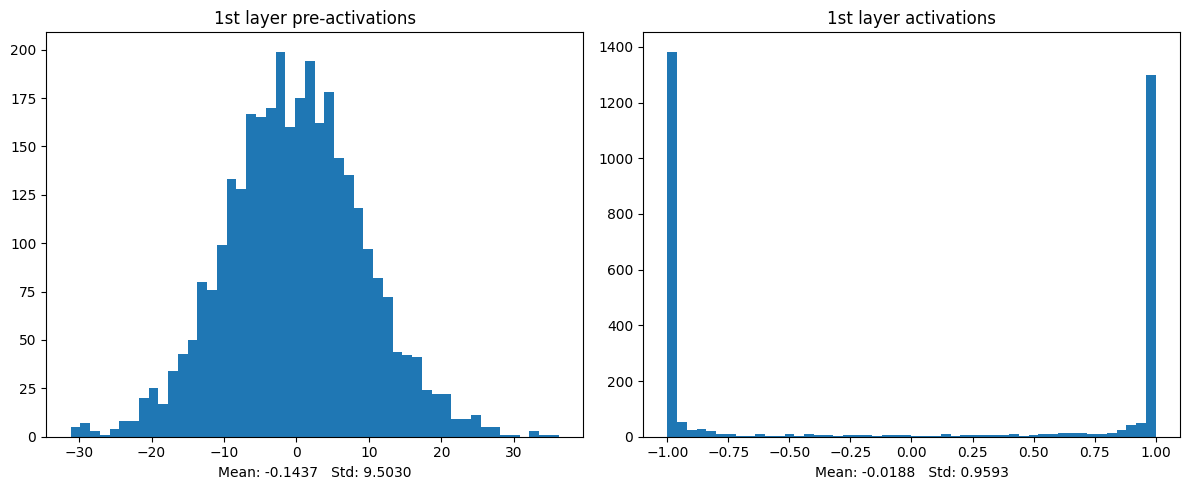

In [175]:
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.hist(h2_prev.view(-1).tolist(), 50)
plt.title('1st layer pre-activations')
plt.xlabel(f'Mean: {h2_prev.mean():.4f}   Std: {h2_prev.std():.4f}')

plt.subplot(122)
plt.hist(h2.view(-1).tolist(), 50)
plt.title('1st layer activations')
plt.xlabel(f'Mean: {h2.mean():.4f}   Std: {h2.std():.4f}')

plt.tight_layout()

If the activations after applying the tanh function are highly saturated (close to 1 or -1), the new gradients become close to zero during backpropagation, which slows down or even halts learning in the neural network:

$$
\text{new gradient} = (1 - \tanh^2(x)) \cdot \text{gradient}
$$

In the figure below, white pixels represent neurons that are highly saturated, effectively destroying the gradient for that example. If an entire row was white, we would have a **dead neuron**. A dead neuron is a neuron that never activates in the non-flat region of tanh and kills all gradients flowing through it, preventing learning.

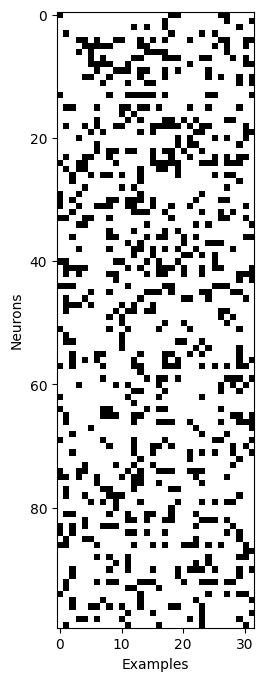

In [176]:
plt.figure(figsize=(10,8))
plt.imshow(h1[:200].T.abs() > 0.99, cmap='gray', interpolation='nearest')
plt.xlabel("Examples")
plt.ylabel("Neurons");

<br>

## Kaiming Initialization

**Kaiming initialization** (also known as He initialization) is a method used to initialize the weights of a neural network in such a way that the gradients flow more effectively through the network. It was introduced in the paper [He et al. (2015). *Delving Deep into Rectifiers*](https://arxiv.org/pdf/1502.01852) and is particularly important when using nonlinear activation functions such as tanh or ReLU. 


The key idea behind Kaiming initialization is to prevent the activations from becoming too large or too small, which can lead to vanishing or exploding gradients as we just show. It adjusts the weights based on a scaling factor that depends on the activation function (gain) and the number of input units to a neuron (fan-in).

\text{std} = \frac{\text{gain}}{\sqrt{\text{fan-in}}}

In [19]:
def initialize_nn(n_hidden = 100):

    g = torch.Generator().manual_seed(1)
    
    W1 = torch.randn((784, n_hidden),      generator=g) * (5/3) / 784**0.5
    b1 = torch.randn(n_hidden,             generator=g)
    W2 = torch.randn((n_hidden, n_hidden), generator=g) * (5/3) / 100**0.5
    b2 = torch.randn(n_hidden,             generator=g)
    W3 = torch.randn((n_hidden, 10),       generator=g) * 0.1
    b3 = torch.randn(10,                   generator=g) * 0
    
    parameters = [W1, b1, W2, b2, W3, b3]
    
    for p in parameters:
        p.requires_grad = True
    
    return parameters

In [20]:
# intialize neural network
parameters = initialize_nn()
W1, b1, W2, b2, W3, b3 = parameters

In [21]:
epochs = 100     # train iterations
lr = 0.1           # learning rate
batch_size = 32
loss_graph = []

for epoch in range(epochs):
    
    # batch construct
    ix = torch.randint(0, train_x.shape[0], (batch_size,))

    # forward pass

    h1_prev = train_x[ix].view(-1, 784) @ W1 + b1
    h1 = torch.tanh(h1_prev)
    h2_prev = h1 @ W2 + b2
    h2 = torch.tanh(h2_prev)
    o = h2@ W3 + b3                    # (examples, n_hidden) = (examples, n_hidden) x (n_hidden, n_hidden) + (n_hidden)
    probs = o.exp() / o.exp().sum(1, keepdims=True)  # softmax

    
    # calculate loss
    loss = -probs[torch.arange(o.shape[0]), train_y[ix]].log().mean()


    loss_graph.append(loss.item())
    if epoch % 10 == 0 or epoch == epochs - 1:
        print(f"Step: {epoch:2d}/{epochs}     Loss: {loss.item():.4f}")
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update parameters
    for p in parameters:
        p.data += -lr * p.grad

Step:  0/100     Loss: 2.5032
Step: 10/100     Loss: 1.8518
Step: 20/100     Loss: 1.7458
Step: 30/100     Loss: 1.0567
Step: 40/100     Loss: 0.9345
Step: 50/100     Loss: 0.8551
Step: 60/100     Loss: 0.5587
Step: 70/100     Loss: 0.7218
Step: 80/100     Loss: 0.3471
Step: 90/100     Loss: 0.6290
Step: 99/100     Loss: 0.3742


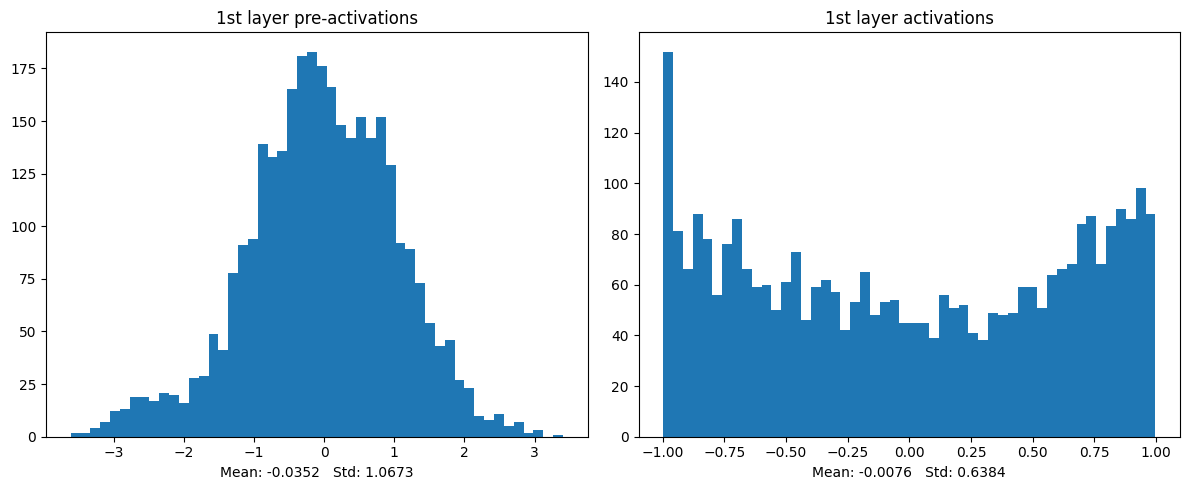

In [22]:
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.hist(h1_prev.view(-1).tolist(), 50)
plt.title('1st layer pre-activations')
plt.xlabel(f'Mean: {h1_prev.mean():.4f}   Std: {h1_prev.std():.4f}')

plt.subplot(122)
plt.hist(h1.view(-1).tolist(), 50)
plt.title('1st layer activations')
plt.xlabel(f'Mean: {h1.mean():.4f}   Std: {h1.std():.4f}')

plt.tight_layout()

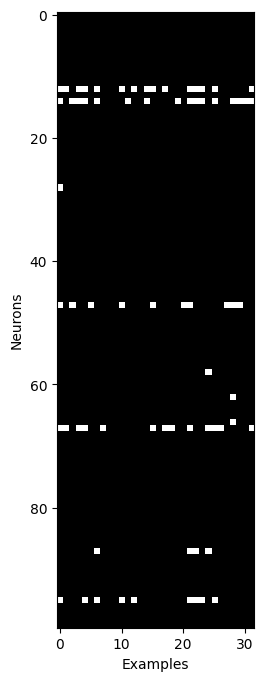

In [23]:
plt.figure(figsize=(10,8))
plt.imshow(h1[:200].T.abs() > 0.99, cmap='gray', interpolation='nearest')
plt.xlabel("Examples")
plt.ylabel("Neurons");